# Some preliminary work

## Libraries and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
fp = "data/dataset.json"

sessions = pd.read_json(fp)
sessions.index.name = "session_id"

assert sessions.index.is_unique

In [3]:
sessions

,browser,os,locale,user_id,gender,location,sites,time,date
session_id,,,,,,,,,
0,Chrome,Windows 8,de-DE,164,m,Canada/Toronto,"[{'site': 'lenta.ru', 'length': 296}, {'site':...",03:57:00,2016-08-14
1,Chrome,Windows 10,pt-PT,99,f,Netherlands/Amsterdam,"[{'site': 'windowsupdate.com', 'length': 56}, ...",13:52:00,2016-05-31
2,Chrome,Windows 10,bg-BG,28,m,Brazil/Rio de Janeiro,"[{'site': 'slack.com', 'length': 158}, {'site'...",17:40:00,2019-04-15
3,Internet Explorer,Ubuntu,en-US,163,f,New Zealand/Auckland,"[{'site': 'amazon.com', 'length': 168}, {'site...",20:23:00,2018-03-25
4,Firefox,Debian,ro-RO,177,f,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 43}, {'site': 'm...",01:10:00,2018-09-08
...,...,...,...,...,...,...,...,...,...
159995,Chrome,Windows 8,bg-BG,74,f,China/Shanghai,"[{'site': 'amazon.com', 'length': 54}, {'site'...",22:33:00,2018-10-15
159996,Internet Explorer,Ubuntu,fr-FR,163,f,New Zealand/Auckland,"[{'site': 'microsoft.com', 'length': 278}, {'s...",21:29:00,2016-03-23
159997,Chrome,Ubuntu,ja-JP,114,m,Russia/Moscow,"[{'site': 'googleapis.com', 'length': 86}, {'s...",19:00:00,2019-03-03


## Extract the site visits to a new dataframe

In [4]:
site_visits = []

for session_id, session in tqdm(sessions.iterrows(), total=len(sessions)):
    for site in session["sites"]:
        site_visits.append({
            "session_id": session_id,
            "site": site["site"],
            "visit_duration": site["length"],
            "is_joe": session["user_id"] == 0,
        })
        
site_visits = pd.DataFrame(site_visits)
site_visits

  0%|          | 0/160000 [00:00<?, ?it/s]

,session_id,site,visit_duration,is_joe
0,0,lenta.ru,296,False
1,0,lenta.ru,69,False
2,0,vk.com,94,False
3,0,lenta.ru,129,False
4,0,wikipedia.org,70,False
...,...,...,...,...
2065868,159999,fisioterapia-online.com,143,False
2065869,159999,ybassets.com,124,False
2065870,159999,googleadservices.com,83,False
2065871,159999,ntvplus.tv,68,False


In [5]:
from os.path import isfile

fp = "results/training.site_visits.csv.gz"

if not isfile(fp):
    site_visits.to_csv(fp, index=False)

## Some parsing on the `sessions` dataframe

In [6]:
from operator import itemgetter

time_parts = sessions["time"].str.split(":")

sessions["hour"] = time_parts.map(itemgetter(0)).astype(int)
hour_fraction = time_parts.map(itemgetter(1)).astype(int)/60
sessions["hour_frac"] = sessions["hour"] + hour_fraction
sessions["hour_frac"] = sessions["hour"].round(1)

sessions["n_sites"] = sessions["sites"].map(len)

sessions["year"] = sessions["date"].dt.year
sessions["month"] = sessions["date"].dt.month
sessions["day"] = sessions["date"].dt.day
sessions["weekday"] = sessions["date"].dt.strftime("%A")

total_session_times = site_visits.groupby("session_id")["visit_duration"].sum()
sessions["duration"] = sessions.index.map(total_session_times)
sessions["duration_min"] = (sessions["duration"]/60).astype(int)

sessions["is_joe"] = sessions["user_id"] == 0

In [7]:
fp = "results/training.sessions.csv.gz"

sessions.to_csv(fp)

In [8]:
joe_sessions = sessions.query("is_joe")

# Exploratory data analysis on the training dataset

In [9]:
sns.set_style("ticks")
sns.set_context("notebook")

## OS

In [10]:
from IPython.display import display, HTML

def display_comparison(data, varname, x_order=None):
    # *data* must have an 'is_joe" boolean column
    joe_data = data.query("is_joe")
    

    s1 = (100 * data[varname].value_counts(normalize=True)).round(1)
    s2 = (100 * joe_data[varname].value_counts(normalize=True)).round(1)

    s1.index.name = varname
    s2.index.name = varname
    s1.name = "All sessions (%)"
    s2.name = "Joe sessions (%)"

    comparison = pd.concat([s1, s2], axis=1).fillna("")
    if x_order:
        comparison = comparison.loc[x_order]
    display(comparison)    

def make_histograms(data, varname, x_order=None, show_comparison=True):
    # *data* must have an 'is_joe" boolean column
    
    if show_comparison:
        display_comparison(data, varname, x_order)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    common_opts = dict(x=varname, stat="percent", ax=ax)
    
    if x_order:
        new_order = data[varname].map(lambda x: x_order.index(x)).sort_values().index
        data = data.loc[new_order]

    joe_data = data.query("is_joe")
    
    sns.histplot(
        data=joe_data,
        color="Orange",
        label="Joe",
        **common_opts
    )
    
    sns.histplot(
        data=data,
        label="All users",
        alpha=0.5,
        **common_opts
    )

    ax.set_ylabel("Sessions (%)")
    ax.legend()
    sns.despine(ax=ax)
    return ax

,All sessions (%),Joe sessions (%)
os,,
Windows 10,34.0,49.6
Windows 8,27.5,
MacOS,17.7,
Windows 7,8.0,
Ubuntu,7.3,50.4
Debian,5.5,


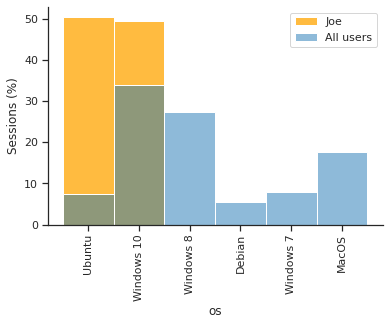

In [11]:
ax = make_histograms(sessions, "os")
_ = plt.xticks(rotation=90)

- Joe uses Ubuntu and Win10 only, in equal proportions.
- Only ~7% of user sessions are from Ubuntu, so this sets Joes appart in some cases.

## Browser

,All sessions (%),Joe sessions (%)
browser,,
Chrome,52.2,49.8
Firefox,21.5,50.2
Safari,17.7,
Internet Explorer,8.5,


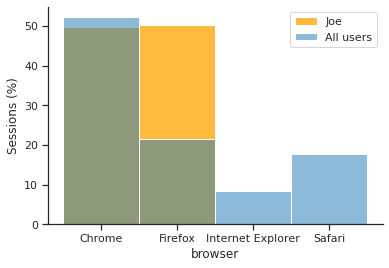

In [12]:
ax = make_histograms(sessions, "browser")

- Joe uses Firefox and Chrome in equal proportions.
- Only 20% of the sessions are in Firefox.

## OS * Browser

,All sessions (%),Joe sessions (%)
os_browser,,
Win10 + Chrome,22.5,24.4
MacOS + Safari,17.7,
Win8 + Chrome,16.1,
Win10 + Firefox,8.5,25.2
Win8 + Firefox,7.7,
Win7 + Chrome,5.3,
Ubuntu + Chrome,5.2,25.4
Win8 + IE,3.6,
Debian + Chrome,3.1,


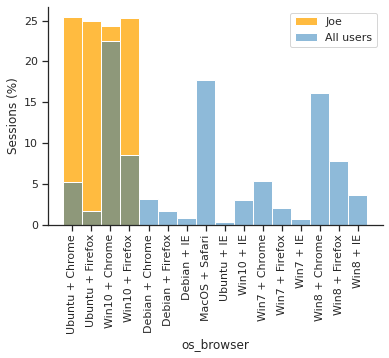

In [13]:
def short_name(name):
    return (
        name
        .replace("Windows ", "Win")
        .replace("Internet Explorer", "IE")
    )

sessions["os_browser"] = \
    (sessions["os"] + " + " + sessions["browser"]).map(short_name)

ax = make_histograms(sessions.sort_values(by="os_browser"), "os_browser")
_ = plt.xticks(rotation=90)

- Joe uses both Firefox and Chrome in both Win10 and Ubuntu in almost equal proportions


## Locale / location

,All sessions (%),Joe sessions (%)
locale,,
ru-RU,10.3,100.0
bg-BG,9.0,
nl-NL,6.8,
de-DE,6.5,
en-SG,6.3,
ja-JP,6.0,
ro-RO,5.5,
en-CA,5.5,
fr-FR,5.0,


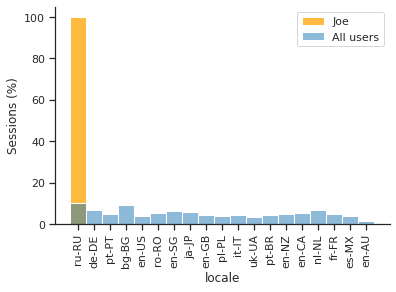

In [14]:
ax = make_histograms(sessions, "locale")
_ = plt.xticks(rotation=90)

,All sessions (%),Joe sessions (%)
location,,
Russia/Moscow,8.9,
USA/New York,7.5,
New Zealand/Auckland,7.0,
Singapore/Singapore,6.2,15.1
USA/Miami,6.0,
USA/Chicago,5.7,23.0
China/Shanghai,5.5,
Japan/Tokyo,5.3,
France/Paris,5.3,39.6


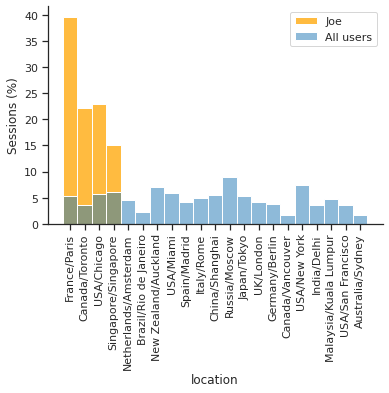

In [15]:
ax = make_histograms(sessions, "location")
_ = plt.xticks(rotation=90)

- Users might have multiple locales. Joe always uses the most common one: `ru-RU`
- Joe browses from Paris 40% of the time, but also from Chicago, Toronto and Singapore.

## Gender

In [16]:
100 * sessions["gender"].value_counts(normalize=True)

m    64.0
f    36.0
Name: gender, dtype: float64

In [17]:
joe_sessions["gender"].value_counts()

m    800
Name: gender, dtype: int64

- Most users are male, like Joe.

## Session dates (year, month, day, weekday)

,All sessions (%),Joe sessions (%)
year_cat,,
2016,29.4,30.1
2017,30.5,30.0
2018,30.5,30.0
2019,9.7,9.9


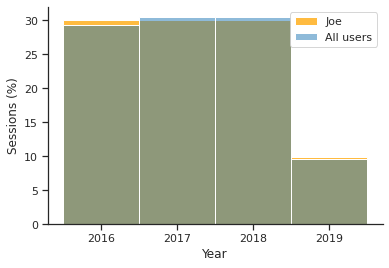

In [18]:
sessions["year_cat"] = sessions["year"].astype(str)

ax = make_histograms(
    sessions,
    "year_cat",
    x_order=["2016", "2017", "2018", "2019"]
)

_ = ax.set_xlabel("Year")

,All sessions (%),Joe sessions (%)
month_cat,,
1,9.2,9.1
2,9.4,8.9
3,10.3,10.6
4,9.4,9.1
5,8.1,7.9
6,7.5,7.6
7,7.8,7.8
8,7.7,8.1
9,7.5,7.5


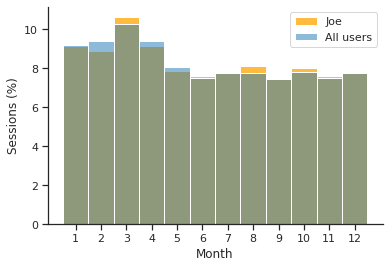

In [19]:
sessions["month_cat"] = sessions["month"].astype(str)

ax = make_histograms(
    sessions,
    "month_cat",
    x_order=[str(m) for m in np.arange(1, 13)]
)
_ = ax.set_xlabel("Month")

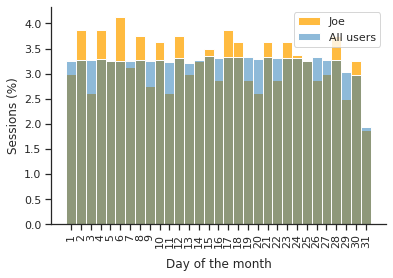

In [20]:
sessions["day_cat"] = sessions["day"].astype(str)

ax = make_histograms(
    sessions,
    "day_cat",
    x_order=[str(d) for d in np.arange(1, 32)],
    show_comparison=False,
)

ax.set_xlabel("Day of the month", labelpad=10)
_ = plt.xticks(rotation=90)

,All sessions (%),Joe sessions (%)
weekday,,
Monday,14.3,14.9
Tuesday,14.3,15.0
Wednesday,14.2,13.8
Thursday,14.3,14.8
Friday,14.3,13.4
Saturday,14.3,14.5
Sunday,14.3,13.8


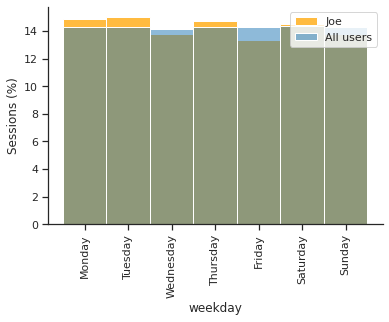

In [21]:
import calendar

ax = make_histograms(
    sessions,
    "weekday",
    x_order=list(calendar.day_name)
)
_ = plt.xticks(rotation=90)

- Session years, months, days and weekdays look the same for Joe as for other users.

## Session hours

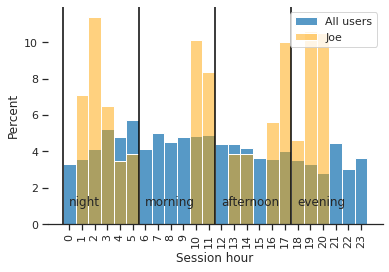

In [22]:
sns.set_style("ticks")

bins = np.arange(0, 25)

ax = sns.histplot(
    data=sessions,
    x="hour",
    stat="percent",
    label="All users",
    bins=bins,
)

sns.histplot(
    data=joe_sessions,
    x="hour",
    stat="percent",
    label="Joe",
    color="Orange",
    alpha=0.5,
    bins=bins,
)

ax.legend(loc="upper right")

ax.set_xticks(np.arange(24) + 0.5)
ax.set_xticklabels(np.arange(24))
plt.xticks(rotation=90)

for hour in [0, 6, 12, 18]:
    ax.axvline(hour, color="k")
    
offset = 0.5
ax.text(0 + offset, 1, "night", ha="left")
ax.text(6 + offset, 1, "morning", ha="left")
ax.text(12 + offset, 1, "afternoon", ha="left")
ax.text(18 + offset, 1, "evening", ha="left")

sns.despine(left=True)
_ = ax.set_xlabel("Session hour")

- Joe might start a session at any moment of the day: night/morning/afternoon/evening
- Joe never starts a session at some particular hours: 6 to 9, 12, 15, 21 to 0. This could be informative.

## Session duration in minutes

In [23]:
sessions["duration_min"].agg([min, max])

min     0
max    64
Name: duration_min, dtype: int64

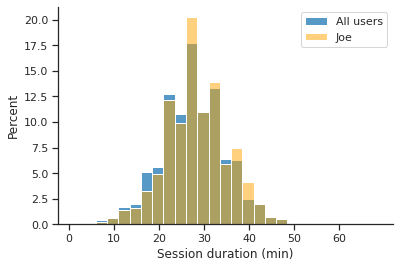

In [24]:
bins = np.arange(1, 70, step=2.5)

ax = sns.histplot(
    data=sessions,
    x="duration_min",
    stat="percent",
    label="All users",
    bins=bins,
)

sns.histplot(
    data=joe_sessions,
    x="duration_min",
    stat="percent",
    label="Joe",
    color="Orange",
    alpha=0.5,
    bins=bins,
)

ax.legend()
ax.set_xticks(np.arange(0, 70, step=10))
sns.despine(ax=ax)

_ = ax.set_xlabel("Session duration (min)")

- Joe sessions' duration are distributed like other users: sessions last around 30 minutes with some variation, almost always between 10 and 50 minutes.

## Number of sites visited in a session

In [25]:
sessions["n_sites"].agg([min, max])

min     1
max    15
Name: n_sites, dtype: int64

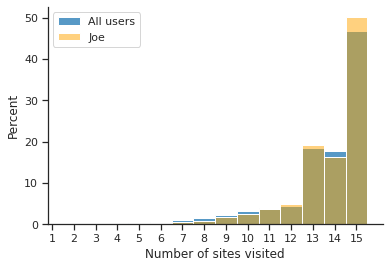

In [26]:
sns.set_style("ticks")

bins = np.arange(1, 16)

ax = sns.histplot(
    data=sessions,
    x="n_sites",
    stat="percent",
    label="All users",
    bins=bins,
)

sns.histplot(
    data=joe_sessions,
    x="n_sites",
    stat="percent",
    label="Joe",
    color="Orange",
    alpha=0.5,
    bins=bins,
)

ax.set_xticks(np.arange(1, 16) - 0.5)
ax.set_xticklabels(np.arange(1, 16))
ax.legend()

sns.despine(ax=ax)

_ = ax.set_xlabel("Number of sites visited")

- Joe has the same distribution of number of sites visited than the average user.

## Users

In [27]:
n_users = len(sessions["user_id"].unique())
print(f"There are {n_users} unique users")

There are 200 unique users


All users have 800 sessions recorded:

In [28]:
sessions["user_id"].value_counts().sort_index()

0      800
1      800
2      800
3      800
4      800
      ... 
195    800
196    800
197    800
198    800
199    800
Name: user_id, Length: 200, dtype: int64

In [29]:
(sessions["user_id"].value_counts() == 800).all()

True